In [120]:
# !gdown 1FbAhm8H7MtPN_CJj-kYuI7jy_CRQsuys

In [121]:
# !unzip -n data.zip 

In [122]:
# !pip install transformers --quiet

In [123]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [124]:
ROOT_DIR = "train_data/"
texts50 = ROOT_DIR + "50texts_tacred/"
cll3 = ROOT_DIR + "coll3_tacred/"
legal = ROOT_DIR + "legal/"
tacred2 = ROOT_DIR + "tacred2/"
tacred3 = ROOT_DIR + "tacred3/"

In [125]:
def create_dataframe(dir):
    df = pd.DataFrame(columns=["fName", "text", "entities"])
    df = df.set_index("fName")
    files = os.listdir(dir)
    for name in files:
        fname, ext = name.split(".")
        with open(dir + name) as f:
            text = f.read()
        if ext == "txt":
            ann_fname = files[files.index(fname + ".ann")]
            with open(dir + ann_fname) as f_ann:
                entities = f_ann.readlines()
            new_entities = []
            for i in range(len(entities)):
                entity_type = entities[i][0]
                entities[i] = entities[i][:-1]
                if entity_type == "T":
                    entities[i] = entities[i].split("\t")
                    entities[i] = entities[i][1:]
                    src = entities[i][1]
                    entities[i] = entities[i][0].split()
                    entities[i].append(src)
                    assert len(entities[i]) <= 5
                    if len(entities[i]) == 5:
                        begin = entities[i][1]
                        inter1, inter2 = entities[i][2].split(";")
                        end = entities[i][3]
                        new_entities.append(
                            [entities[i][0], begin, inter1, entities[i][4]]
                        )
                        new_entities.append(
                            [entities[i][0], inter2, end, entities[i][4]]
                        )
                    else:
                        new_entities.append(entities[i])
            df.loc[fname] = [text, new_entities]
    return df

In [126]:
df1 = create_dataframe(texts50)
df2 = create_dataframe(cll3)
df3 = create_dataframe(legal)
df4 = create_dataframe(tacred2)
df5 = create_dataframe(tacred3)

In [127]:
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0]

841

In [128]:
total_df = pd.concat([df1, df2, df3, df4, df5])

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [130]:
tokenizer = AutoTokenizer.from_pretrained("Evolett/rubert-tiny2-finetuned-ner")

In [131]:
def identify_tokens(df_sample):
    sample_text = df_sample["text"]
    sample_en = df_sample["entities"]
    sample_text_tokenized = tokenizer.tokenize(sample_text)
    trash_symbols_count = []
    for i in range(len(sample_text)):
        cur = (
            1
            if (
                sample_text[i] == " "
                or sample_text[i] == "\n"
                or sample_text[i] == "\xa0"
            )
            else 0
        )
        if i == 0:
            trash_symbols_count.append(cur)
        else:
            trash_symbols_count.append(trash_symbols_count[-1] + cur)
    cur_entity_id = 0
    processed_symbols = 0
    mappings = []
    begin = int(sample_en[cur_entity_id][1])
    end = int(sample_en[cur_entity_id][2])
    assert end < len(trash_symbols_count)
    begin -= trash_symbols_count[begin]
    end -= trash_symbols_count[end]

    for token in sample_text_tokenized:
        while processed_symbols > end and (cur_entity_id + 1) < len(sample_en):
            cur_entity_id += 1
            begin = int(sample_en[cur_entity_id][1])
            end = int(sample_en[cur_entity_id][2]) - 1
            begin -= trash_symbols_count[begin]
            end -= trash_symbols_count[end]
        if begin <= processed_symbols <= end:
            first_token = not (
                len(mappings) != 0 and sample_en[cur_entity_id] == mappings[-1][1]
            )
            mappings.append((token, sample_en[cur_entity_id], first_token))
        else:
            mappings.append((token, False))
        subword_check = token[:2] == '##'
        processed_symbols = processed_symbols + len(token) - int(subword_check) * 2

    for i in range(len(mappings)):
        if len(mappings[i]) == 2:
            mappings[i] = "O"
        else:
            if mappings[i][-1]:
                mappings[i] = "B-" + mappings[i][1][0]
            else:
                mappings[i] = "I-" + mappings[i][1][0]
    mappings.insert(0, "O")  # start token
    mappings.append("O")  # end token
    return mappings

In [132]:
total_df["tokenized_text"] = total_df["text"].apply(tokenizer.tokenize)
total_df["tokenizer_output"] = total_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)

# add start and end tokens to map tokenizer output
total_df["tokenized_text"] = total_df["tokenized_text"].apply(
    lambda x: ["<s>"] + x + ["</s>"]
)
total_df["classified_tokens"] = total_df.apply(identify_tokens, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (2392 > 2048). Running this sequence through the model will result in indexing errors


In [133]:
total_df.reset_index(inplace=True)
total_df.head()

,fName,text,entities,tokenized_text,tokenizer_output,classified_tokens
0,104189_text,Полиция Бельгии арестовала двух человек по под...,"[[ORGANIZATION, 0, 15, Полиция Бельгии], [COUN...","[<s>, Полиция, Бельгии, арестовал, ##а, двух, ...","[input_ids, token_type_ids, attention_mask]","[O, B-ORGANIZATION, I-ORGANIZATION, O, O, B-NU..."
1,119336_text,"Семья Обамы приобрела дом в Вашингтоне за 8,1 ...","[[PERSON, 6, 11, Обамы], [CITY, 28, 38, Вашинг...","[<s>, Семья, Обамы, приобрела, дом, в, Вашингт...","[input_ids, token_type_ids, attention_mask]","[O, O, B-PERSON, O, O, O, B-CITY, O, B-MONEY, ..."
2,11766_text,Скончался бывший премьер-министр России Виктор...,"[[PROFESSION, 17, 32, премьер-министр], [COUNT...","[<s>, Скончался, бывший, премьер, -, министр, ...","[input_ids, token_type_ids, attention_mask]","[O, O, O, B-PROFESSION, I-PROFESSION, I-PROFES..."
3,11899_text,Странное преступление против семьи россиян в А...,"[[NATIONALITY, 35, 42, россиян], [COUNTRY, 45,...","[<s>, Странно, ##е, преступление, против, семь...","[input_ids, token_type_ids, attention_mask]","[O, O, O, O, O, O, B-NATIONALITY, O, B-COUNTRY..."
4,120890_text,Важные перемены в жизни рэпера Jay Z: Он помен...,"[[PERSON, 31, 36, Jay Z], [PERSON, 62, 67, JAY...","[<s>, Важ, ##ные, перемены, в, жизни, рэпера, ...","[input_ids, token_type_ids, attention_mask]","[O, O, O, O, O, O, O, B-PERSON, I-PERSON, I-PE..."


<AxesSubplot:>

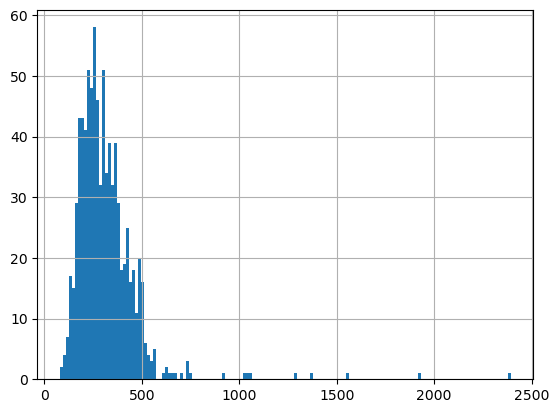

In [134]:
total_df["tokenized_text"].apply(len).hist(bins=150)

In [135]:
lens = total_df["classified_tokens"].apply(len)
print(
    f"Number of samples in train dataset, which have more tokens, when BERT can process - {lens[lens > 2048].count() / lens.count() * 100:.3f}%"
)

Number of samples in train dataset, which have more tokens, when BERT can process - 0.119%


Dataset have 0.11% of samples, what can't be processed by BERT(For example, in document '1109' input text tokenized at more than 2392 tokens). To deal with this problem, we can use sliding window approach. But in our case, number of samples with >2038 tokens in insignificant, so we can pay no attention to this.

In [ ]:
total_df["input_ids"] = total_df["tokenizer_output"].apply(lambda x: x["input_ids"])
total_df["attention_mask"] = total_df["tokenizer_output"].apply(
    lambda x: x["attention_mask"]
)

In [ ]:
sample = total_df[total_df["fName"] == "1109"]
iids = sample["input_ids"]
attn = sample["attention_mask"]
iids.values[0].shape, attn.values[0].shape, len(sample["tokenized_text"].values[0])

In [ ]:
# drop useless columns
total_df.drop(["entities", "text", "tokenizer_output"], axis=1, inplace=True)

In [ ]:
total_df.reset_index(inplace=True)
total_df.drop("index", axis=1, inplace=True)

In [ ]:
# test token mapping for the sample
n = 25
sample = total_df.iloc[n]
sample_tokens = sample["tokenized_text"]
sample_entities = sample["classified_tokens"]
a = np.array([sample_tokens, sample_entities])
a.T

In [ ]:
unique_entities = []
for sample in total_df["classified_tokens"]:
    for token in sample:
        unique_entities.append(token)
unique_entities = np.unique(unique_entities)

In [ ]:
id2label = {}
label2id = {}

for i in range(len(unique_entities)):
    id2label[i] = unique_entities[i]
    label2id[unique_entities[i]] = i

In [ ]:
labels_num = len(unique_entities)

In [ ]:
labels_num

In [ ]:
#model architecture
class BertTokenClassification(torch.nn.Module):
    def __init__(self):
        super(BertTokenClassification, self).__init__()
        self.bert = AutoModelForTokenClassification.from_pretrained("Evolett/rubert-tiny2-finetuned-ner")

        self.bert.id2label = id2label
        self.bert.label2id = label2id
        self.bert.num_labels = labels_num
        self.bert.classifier = torch.nn.Linear(312, labels_num)

    def forward(self, input_id, mask, label=None):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label)
        return output

In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    @staticmethod
    def df_sample_to_tensor(row):
        data = row["input_ids"]
        labels = row["classified_tokens"]
        labels = list(map(lambda x: label2id[x], labels))
        labels = torch.tensor(labels)
        data = torch.squeeze(data).int()
        # print(labels.shape, data.shape)
        return data, labels

    def __getitem__(self, idx):
        return self.df_sample_to_tensor(self.df.iloc[idx])

In [ ]:
# complement input ids and attention mask
# to 2048 elements, to bring all tensors to the same shape
def tokenization_complement(tensor):
    complement_size = 2048 - tensor.shape[1]
    if complement_size < 0:
        return tensor[:, :2048]
    zeros_complement = torch.zeros((1, complement_size))
    new_sample = torch.cat(
        (
            tensor,
            zeros_complement,
        ),
        dim=1,
    )
    assert new_sample.shape[1] == 2048
    return new_sample


# complement labels to the form of tensors
def labels_complement(labels):
    complement_size = 2048 - len(labels)
    if complement_size < 0:
        return labels[:2048]
    new_labels = labels
    for i in range(complement_size):
        new_labels.append("O")
    return new_labels

In [ ]:
total_df["input_ids"] = total_df["input_ids"].apply(tokenization_complement)
total_df["attention_mask"] = total_df["attention_mask"].apply(tokenization_complement)

In [ ]:
total_df["classified_tokens"] = total_df["classified_tokens"].apply(labels_complement)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(total_df, train_size=0.85)

In [ ]:
BATCH_SIZE = 4
lr = 3e-4
EPOCH_NUMBER = 10


def train_loop(model, train_d, val_d, epoch_num=EPOCH_NUMBER):
    train_dataset = TextDataset(train_d)
    val_dataset = TextDataset(val_d)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epoch_num):
        acc_train = 0
        cur_loss_train = 0
        acc_val = 0
        loss_val = 0

        model.train()
        for data, labels in tqdm(train_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]

            for i in range(logits.shape[0]):
                clean_logits = logits[i][labels[i] != 58]
                clean_labels = labels[i][labels[i] != 58]
                
                predictions = clean_logits.argmax(dim=1)
                acc = (predictions == clean_labels).float().mean()
                acc_train += acc
                cur_loss_train += loss.item()
                train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        model.eval()
        for data, labels in tqdm(val_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]
            for i in range(logits.shape[0]):
                clean_logits = logits[i][labels[i] != 58]
                clean_labels = labels[i][labels[i] != 58]

                predictions = clean_logits.argmax(dim=1)
                acc = (predictions == clean_labels).float().mean()
                acc_val += acc
                loss_val += loss.item()
                val_losses.append(loss.item())

        print(
            f"Epochs: {epoch + 1} | train Loss: {cur_loss_train / len(train_d): .3f} | train Accuracy: {acc_train / len(train_d): .3f}"
        )
        print(
            f"val Loss: {loss_val / len(val_d): .3f} | val Accuracy: {acc_val / len(val_d): .3f}"
        )

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = BertTokenClassification().to(device)

In [ ]:
train_loop(model, train_data, val_data)

In [ ]:
# model.load_state_dict(torch.load('model.pth'))

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
test_dir = "test_data/"

In [ ]:
texts = []
f_names = []
for file_name in os.listdir(test_dir):
    file_path = test_dir + file_name
    if file_name.split(".")[1] == "txt":
        with open(file_path) as f:
            cur_text = f.read()
        texts.append(cur_text)
        f_names.append(file_name)

test_df = pd.DataFrame({"fName": f_names, "text": texts})

In [ ]:
test_df["tokenized_text"] = test_df["text"].apply(tokenizer.tokenize)

In [ ]:
test_df["tokenized_text"] = test_df["tokenized_text"].apply(
    lambda x: ["START"] + x + ["END"]
)

In [ ]:
test_df["tokenized_text"].apply(len).hist(bins=50)

In [ ]:
test_df["tokenizer_output"] = test_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)

In [ ]:
test_df

In [ ]:
def model_inference(sample):
    text = sample["text"]
    model_input = tokenizer(text)
    input_len = len(model_input["input_ids"])
    input_ids = torch.tensor(model_input["input_ids"]).unsqueeze(0).to(device)
    # print(input_len)

    attention_mask = torch.tensor(model_input["attention_mask"]).unsqueeze(0).to(device)
    output = model(input_ids, attention_mask)
    logits = output[0]
    predictions = logits.argmax(dim=2).squeeze(0)

    result = []
    for prediction in predictions:
        result.append(id2label[prediction.item()])

    text_tokenized = sample["tokenized_text"]
    arr = np.vstack((text_tokenized, result))
    arr = arr.T
    # print(arr)

    text = sample["text"]
    processed_tokens = 1
    cur_token = arr[processed_tokens][0]
    cur_label = arr[processed_tokens][1]
    ans = []
    for i in range(len(text)):
        if cur_token == "END":
            break

        if cur_token == "[UNK]":
            processed_tokens += 1
            cur_token = arr[processed_tokens][0]
            cur_label = arr[processed_tokens][1]

        token_len = len(cur_token)
        cur_token_fixed = cur_token

        if cur_token[:2] == "##":
            token_len -= 2
            cur_token_fixed = cur_token[2:]

        assert len(text[i : i + token_len]) == len(cur_token_fixed)
        if len(text[i : i + token_len]) != len(cur_token_fixed):
            print(text[i : i + token_len], "--", len(text[i : i + token_len]))
            print(cur_token_fixed, "--", len(cur_token_fixed))
            return

        if text[i : i + token_len] == cur_token_fixed:
            ans.append((i, i + token_len, cur_token, cur_label))
            processed_tokens += 1
            cur_token = arr[processed_tokens][0]
            cur_label = arr[processed_tokens][1]

    ans1 = []
    i = 0
    while i < len(ans):
        label = ans[i][3]
        if label[0] != "O":
            total_word = ans[i][2]
            begin = ans[i][0]
            end = ans[i][1]
            j = i + 1
            while ans[j][3][0] == "I":
                cur_word = ans[j][2]

                if cur_word[0:2] != "##":
                    cur_word = " " + cur_word
                else:
                    cur_word = cur_word[2:]

                total_word += cur_word
                end = ans[j][1]
                j += 1
            ans1.append((begin, end, total_word, label[2:]))
            i = j
        else:
            i += 1
    return ans1

In [ ]:
sample = test_df.iloc[2]
model_inference(sample)

In [ ]:
file = open("answer.txt", 'w')

for i in range(test_df.shape[0]):
    sample = test_df.iloc[i]
    fname = sample['fName']
    fname = fname.split('.')[0] + '.ann'
    res = model_inference(sample)
    file.write(fname + '\n')
    for elem in res:
        begin = elem[0]
        end = elem[1]
        substr = elem[2]
        label = elem[3]
        result_str = label + ' ' +  str(begin) + ' ' + str(end) + '\n'
        file.write(result_str)

file.close()